In [1]:
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
URI = "database-1.c5ekejexdq4k.us-east-1.rds.amazonaws.com"
PORT = "3306"
DB = "dublin_bike"
USER = "admin"
PASSWARD = "group888"

engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(USER, PASSWARD, URI, PORT, DB))

In [3]:
df_bike = pd.read_sql_table("bike_availibility", engine, parse_dates="True", index_col=0)
df_weather = pd.read_sql_table("weather", engine, parse_dates="True", index_col=0)


In [4]:
display(df_bike.head())
print(df_bike.shape)

,ID,Number,Time,Available_bike_stands,Available_bikes,Status
0,3083,42,2022-02-16 00:10:58,3,27,OPEN
1,3084,30,2022-02-16 00:10:58,17,3,OPEN
2,3085,54,2022-02-16 00:10:58,16,17,OPEN
3,3086,108,2022-02-16 00:10:58,19,16,OPEN
4,3087,56,2022-02-16 00:10:58,26,14,OPEN


(452980, 6)


In [5]:
display(df_weather.head())
print(df_weather.shape)

,ID,Time,Weather,Temp,Feels_like,Humidity
0,29,2022-02-16 00:10:58,Clear,15.07,13.44,31
1,30,2022-02-16 00:20:57,Clear,14.99,13.38,32
2,31,2022-02-16 00:31:55,Clear,14.80,13.17,32
3,32,2022-02-16 00:41:54,Clear,14.88,13.29,33
4,33,2022-02-16 00:51:26,Clear,14.64,13.02,33


(4118, 6)


In [6]:
df_combine = df_bike.merge(df_weather,left_on='Time', right_on='Time')
df_combine
# df_combine.info()

,ID_x,Number,Time,Available_bike_stands,Available_bikes,Status,ID_y,Weather,Temp,Feels_like,Humidity
0,3083,42,2022-02-16 00:10:58,3,27,OPEN,29,Clear,15.07,13.44,31
1,3084,30,2022-02-16 00:10:58,17,3,OPEN,29,Clear,15.07,13.44,31
2,3085,54,2022-02-16 00:10:58,16,17,OPEN,29,Clear,15.07,13.44,31
3,3086,108,2022-02-16 00:10:58,19,16,OPEN,29,Clear,15.07,13.44,31
4,3087,56,2022-02-16 00:10:58,26,14,OPEN,29,Clear,15.07,13.44,31
...,...,...,...,...,...,...,...,...,...,...,...
452975,456058,39,2022-04-04 20:50:51,18,2,OPEN,4146,Clear,19.14,18.52,54
452976,456059,83,2022-04-04 20:50:51,17,23,OPEN,4146,Clear,19.14,18.52,54
452977,456060,92,2022-04-04 20:50:51,14,26,OPEN,4146,Clear,19.14,18.52,54
452978,456061,21,2022-04-04 20:50:51,4,26,OPEN,4146,Clear,19.14,18.52,54


In [7]:
# Specific group
df_test_station=df_combine.groupby("Number").get_group(42)
df_test_station['Status'] = df_test_station['Status'].astype("category")
df_test_station["Weather"] = df_test_station["Weather"].astype("category")
df_test_station["Feels_like"] = df_test_station["Feels_like"].astype(float)
df_test_station = df_test_station.drop(['Number', 'ID_x', 'ID_y', 'Status'], axis=1)

/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_35506/2252232096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station['Status'] = df_test_station['Status'].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_35506/2252232096.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_station["Weather"] = df_test_station["Weather"].astype("category")
/var/folders/rf/mclkwt4528d_9wmdvyfrz0680000gn/T/ipykernel_35506/2252232096.py:5: SettingWithCopyWarning: 
A

In [8]:
df_test_station = df_test_station.set_index('Time')

In [9]:
df_test_station.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4118 entries, 2022-02-16 00:10:58 to 2022-04-04 20:50:51
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Available_bike_stands  4118 non-null   int64   
 1   Available_bikes        4118 non-null   int64   
 2   Weather                4118 non-null   category
 3   Temp                   4118 non-null   float64 
 4   Feels_like             4118 non-null   float64 
 5   Humidity               4118 non-null   int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 197.3 KB


/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/matplotlib/axes/_base.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


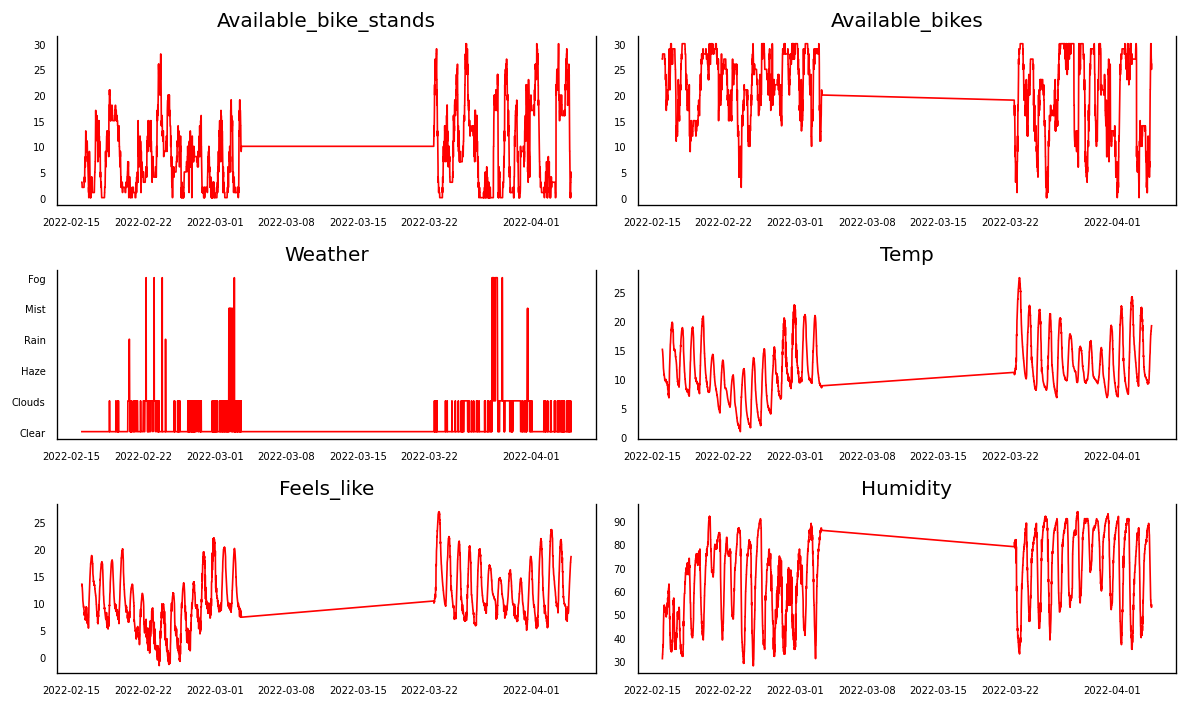

In [10]:
# Reference
# Plot 
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_test_station[df_test_station.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_test_station.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'

df_test_station = df_test_station.drop(["Weather"], axis=1)

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(df_test_station, variables = df_test_station.columns) 

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1
  wa

,Available_bike_stands_x,Available_bikes_x,Temp_x,Feels_like_x,Humidity_x
Available_bike_stands_y,1.0,0.0,0.0,0.0000,0.0
Available_bikes_y,0.0,1.0,0.0,0.0000,0.0
Temp_y,0.0,0.0,1.0,0.0001,0.0
Feels_like_y,0.0,0.0,0.0,1.0000,0.0
Humidity_y,0.0,0.0,0.0,0.0000,1.0


In [12]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_test_station)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Available_bike_stands ::  252.48    > 60.0627   =>   True
Available_bikes ::  131.65    > 40.1749   =>   True
Temp   ::  63.85     > 24.2761   =>   True
Feels_like ::  7.14      > 12.3212   =>   False
Humidity ::  0.0       > 4.1296    =>   False


In [13]:
df_test_station = df_test_station.drop(['Feels_like'], axis=1)
nobs = 12
df_train, df_test = df_test_station[0:-nobs], df_test_station[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(4106, 4)
(12, 4)


In [14]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 6), 'pvalue':round(r[1], 6), 'n_lags':round(r[2], 6), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [15]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Available_bike_stands" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.119846
 No. Lags Chosen       = 25
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Available_bikes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.042761
 No. Lags Chosen       = 22
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [16]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -4.995922600406985
BIC :  -4.965131072894748
FPE :  0.006765476420057205
HQIC:  -4.985022161235704 

Lag Order = 2
AIC :  -5.114143923390405
BIC :  -5.058707805961891
FPE :  0.0060111217820414805
HQIC:  -5.0945188657355 

Lag Order = 3
AIC :  -5.17174108503927
BIC :  -5.091650265637126
FPE :  0.005674680593856245
HQIC:  -5.1433876130797085 

Lag Order = 4
AIC :  -5.188506623575761
BIC :  -5.083750983442412
FPE :  0.005580335194134408
HQIC:  -5.151420938901661 

Lag Order = 5
AIC :  -5.24609913470918
BIC :  -5.11666854838074
FPE :  0.005268030124927061
HQIC:  -5.200277436319413 

Lag Order = 6
AIC :  -5.296287474128364
BIC :  -5.142171809428549
FPE :  0.005010162799225258
HQIC:  -5.2417259584281615 

Lag Order = 7
AIC :  -5.401891692934244
BIC :  -5.223080810968276
FPE :  0.0045080492918233945
HQIC:  -5.338586553732791 

Lag Order = 8
AIC :  -5.4876590263684495
BIC :  -5.284142781516949
FPE :  0.0041375244297879475
HQIC:  -5.4156064548764835 

Lag Order = 9
AIC :  -

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
model = VAR(df_train)
result = model.fit(4)
result.summary()

/opt/anaconda3/envs/comp30830/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Apr, 2022
Time:                     21:56:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -5.08375
Nobs:                     4102.00    HQIC:                  -5.15142
Log likelihood:          -12572.3    FPE:                 0.00558034
AIC:                     -5.18851    Det(Omega_mle):      0.00548878
--------------------------------------------------------------------
Results for equation Available_bike_stands
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            9.118447         1.944552            4.689           0.000
L1.Available_bike_stands         0.814447         0.182650            4.459           0.000


In [18]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)

out = durbin_watson(result.resid)

for col, val in zip(df_test_station.columns, out):
    print(adjust(col), ':', round(val, 2))
    

Available_bike_stands : 2.0
Available_bikes : 2.0
Temp   : 2.07
Humidity : 2.04


In [19]:
lagged_Values = df_train.values[-12:]
pred = result.forecast(y=lagged_Values, steps=12) 

df_forecast=pd.DataFrame(data=pred, index=df_test_station.index[-nobs:], columns=df_test_station.columns + '_predict')
df_forecast

,Available_bike_stands_predict,Available_bikes_predict,Temp_predict,Humidity_predict
Time,,,,
2022-04-04 19:01:35,0.981875,29.017166,17.489208,55.330716
2022-04-04 19:10:43,0.979604,29.013619,17.567340,55.006281
2022-04-04 19:20:42,0.961348,29.024970,17.543425,55.205382
2022-04-04 19:30:48,0.975875,29.004858,17.511865,55.262866
2022-04-04 19:40:39,1.000324,28.975334,17.466104,55.416558
2022-04-04 19:50:30,1.036413,28.934507,17.403324,55.640896
2022-04-04 20:02:08,1.078150,28.888240,17.336002,55.869706
2022-04-04 20:10:44,1.125145,28.836998,17.264001,56.118980
2022-04-04 20:21:12,1.176496,28.781656,17.188757,56.380153


In [20]:
df_test

,Available_bike_stands,Available_bikes,Temp,Humidity
Time,,,,
2022-04-04 19:01:35,0,30,17.75,56
2022-04-04 19:10:43,0,30,17.75,56
2022-04-04 19:20:42,1,29,17.94,55
2022-04-04 19:30:48,0,30,17.96,55
2022-04-04 19:40:39,0,30,18.19,54
2022-04-04 19:50:30,2,28,18.19,54
2022-04-04 20:02:08,3,27,18.36,54
2022-04-04 20:10:44,3,27,18.56,54
2022-04-04 20:21:12,3,27,18.89,54


<AxesSubplot:xlabel='Time'>

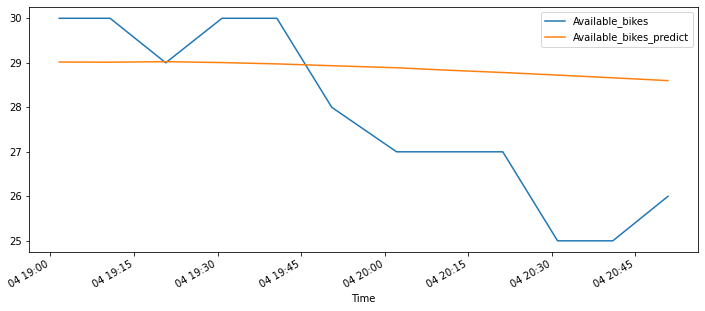

In [21]:
# Available bike predict
df_test["Available_bikes"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bikes_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

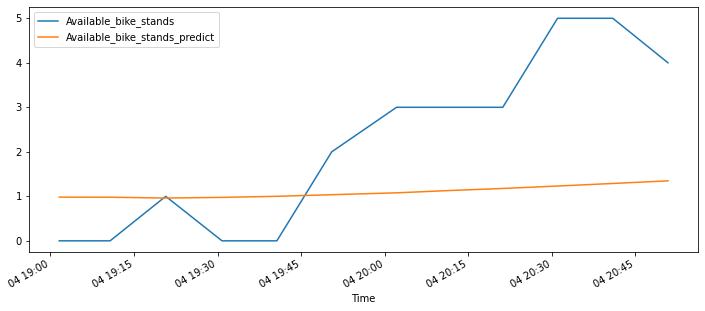

In [22]:
# Available bike stands
df_test["Available_bike_stands"].plot(figsize=(12,5),legend=True)
df_forecast['Available_bike_stands_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

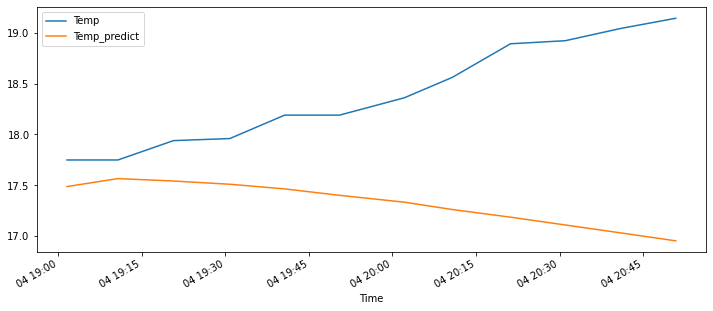

In [23]:
# Temp
df_test["Temp"].plot(figsize=(12,5),legend=True)
df_forecast['Temp_predict'].plot(legend=True)

<AxesSubplot:xlabel='Time'>

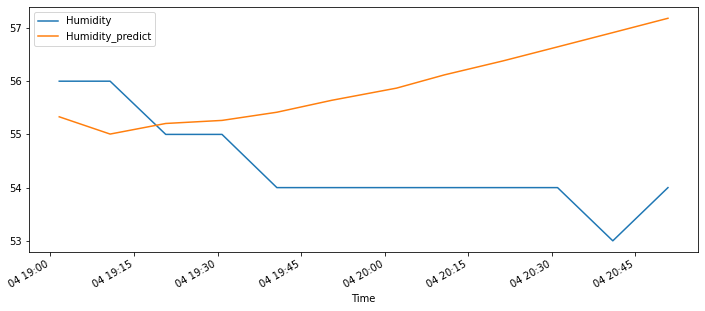

In [24]:
# Humidity
df_test["Humidity"].plot(figsize=(12,5),legend=True)
df_forecast['Humidity_predict'].plot(legend=True)

In [25]:
def rmse (forecast, actual):
    return np.mean(((forecast - actual)**2)**0.5)

# Rmse Available bikes
print("RMSE for available bikes: ", rmse(df_forecast['Available_bikes_predict'], df_test["Available_bikes"]))
# RMSE for available bike stands
print("RMSE for available bikes stands: ", rmse(df_forecast['Available_bike_stands_predict'], df_test["Available_bike_stands"]))
# RMSE for Temp
print("RMSE for Temp: ", rmse(df_forecast['Temp_predict'], df_test["Temp"]))
# RMSE for Humidity
print("RMSE for Humidity: ", rmse(df_forecast['Humidity_predict'], df_test["Humidity"]))

RMSE for available bikes:  1.7033976794794807
RMSE for available bikes stands:  1.724380596881588
RMSE for Temp:  1.068019036063567
RMSE for Humidity:  1.7747859275248377
